In [0]:
!pip install musdb
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from google.colab import drive
import h5py
import json
drive.mount('/content/drive')


     |████████████████████████████████| 512kB 8.3MB/s 


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.2.0
/device:GPU:0
Num GPUs Available:  1


In [0]:
import musdb
mus = musdb.DB('/content/drive/My Drive/musdb')

In [0]:
'''track_list = []
vocal_list = []
stft_list = []
vocal_stft_list = []
num_seg = 25
num_samples = num_seg*mus[0].rate
num_freq = 512
shape = (len(mus),num_freq+1,int(np.ceil(num_samples/(2*num_freq))*2+1))
stft_list = np.zeros(shape,dtype=complex)
vocal_stft_list = np.zeros(shape,dtype=complex)'''

'''for i in tqdm(range(len(mus))):
    track = mus[i]
    interval_start = int(np.random.uniform(0, len(track.audio)-num_samples))
    f,t, stft_data = signal.stft(track.audio[interval_start:interval_start + num_samples,0] + track.audio[interval_start:interval_start + num_samples,1], track.rate, nperseg=(2*num_freq),noverlap=num_freq)
    #f,t, stft_data = signal.stft(track.audio[:,0] + track.audio[:,1], track.rate, nperseg=(2*num_freq),noverlap=num_freq)
    stft_list[i] = stft_data
    f,t, vocal_stft =  signal.stft(track.targets['vocals'].audio[interval_start:interval_start + num_samples,0] + track.targets['vocals'].audio[interval_start:interval_start + num_samples,1], track.rate,nperseg=1024,noverlap=512)
    #f,t, vocal_stft =  signal.stft(track.targets['vocals'].audio[:,0] + track.targets['vocals'].audio[:,1], track.rate,nperseg=1024,noverlap=512)
    f,t, acc_stft = signal.stft(track.targets['accompaniment'].audio[interval_start:interval_start + num_samples,0] + track.targets['accompaniment'].audio[interval_start:interval_start + num_samples,0], track.rate,nperseg=1024,noverlap=512)
    vocal_stft_list[i] = vocal_stft
'''
    

 39%|███▊      | 58/150 [20:44<15:32, 10.14s/it]

ValueError: ignored

In [0]:
def append_to_dataset(datapath,dataset_name,new_data):
  with h5py.File(datapath, mode='a') as h5f:
    dset = h5f[dataset_name]
    shape_old = dset.shape
    shape_new = list(dset.shape)
    shape_new[0] += new_data.shape[0]
    shape_new = tuple(shape_new)
    dset.resize(shape_new)
    #print(shape_old,shape_new)
    dset[shape_old[0]:shape_new[0],:] = new_data
    h5f.flush()

In [0]:
hf.close()

NameError: ignored

In [0]:
track_list = []
vocal_list = []
stft_list = []
vocal_stft_list = []

num_freq = 512

datapath = '/content/drive/My Drive/Projeto Final/data/2_stems_saved_auto.h5'
hf = h5py.File(datapath, 'w')

#hf.create_dataset('Y_train_acc',chunks=True,maxshape=(None,513))
path = '/content/drive/My Drive/Projeto Final/data/norm_data_full.json'
norm_data = {}

for i in tqdm(range(100)):
    track = mus[i]
    _,_,stft_data = signal.stft(track.audio[:,0] + track.audio[:,1], track.rate, nperseg=(2*num_freq),noverlap=num_freq) # lembrar que a função cospe f,t, data
    #f,t, stft_data = signal.stft(track.audio[:,0] + track.audio[:,1], track.rate, nperseg=(2*num_freq),noverlap=num_freq)
    _,_,acc_stft = signal.stft(track.targets['accompaniment'].audio[:,0] + track.targets['accompaniment'].audio[:,0], track.rate,nperseg=1024,noverlap=512)
    _,_,vocal_stft =  signal.stft(track.targets['vocals'].audio[:,0] + track.targets['vocals'].audio[:,1], track.rate,nperseg=1024,noverlap=512)
    if i ==0:
      hf.create_dataset('X_train',chunks=True,maxshape=(None,513),data=stft_data.T)
      hf.create_dataset('Y_train_vocal',chunks=True,maxshape=(None,513),data=vocal_stft.T)
      hf.create_dataset('Y_train_acc',chunks=True,maxshape=(None,513),data=acc_stft.T)
      norm_data['X_max'] = np.log(np.max(np.abs(stft_data))+1e-7)
      norm_data['X_min'] = np.log(np.min(np.abs(stft_data))+1e-7)
      with open(path, 'w') as fp:
          json.dump(norm_data, fp)
      hf.close()
    else:
      append_to_dataset(datapath=datapath,dataset_name='X_train',new_data=stft_data.T)
      append_to_dataset(datapath=datapath,dataset_name='Y_train_vocal',new_data=vocal_stft.T)
      append_to_dataset(datapath=datapath,dataset_name='Y_train_acc',new_data=acc_stft.T)
      if(np.max(np.abs(stft_data[2]))>=norm_data['X_max']):
        norm_data['X_max'] = np.log(np.max(np.abs(stft_data))+1e-7)
        with open(path, 'w') as fp:
          json.dump(norm_data, fp)
      if(np.min(np.abs(stft_data[2]))<=norm_data['X_min']):
        norm_data['X_min'] = np.log(np.min(np.abs(stft_data))+1e-7)
        with open(path, 'w') as fp:
          json.dump(norm_data, fp)
      

    #vocal_stft_list[i] = vocal_stft

 76%|███████▌  | 76/100 [28:04<11:13, 28.05s/it]

OSError: ignored

In [0]:
import json
norm_data = {}
norm_data['X_max'] = max_X_train
norm_data['X_min'] = min_X_train
path = '/content/drive/My Drive/Projeto Final/data/norm_data_full.json' 
with open(path, 'w') as fp:
    json.dump(norm_data, fp)

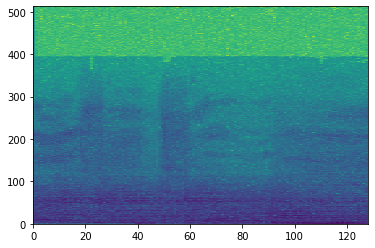

In [0]:
hf = h5py.File(datapath, 'r')
plt.pcolormesh(np.abs(np.log(hf['X_train'][0:128].T+1e-8)))

In [0]:
stft_list = np.hstack(stft_list).T
vocal_stft_list = np.hstack(vocal_stft_list).T
acc_stft_list = np.hstack(acc_stft_list).T

In [0]:
teste.shape

In [0]:
ipd.Audio(track.audio[0:num_samples,0],rate=mus[0].rate)

In [0]:
import matplotlib.cm as cm
num_seg = 10
num_samples = num_seg*mus[0].rate
f,t, stft_data = signal.stft(mus[0].targets['vocals'].audio[0:num_samples,0] + mus[0].targets['vocals'].audio[0:num_samples,1], mus[0].rate,nperseg=1024,noverlap=512)
print(len(stft_data[1]))

i = 3

freq_bins = 513
plt.pcolormesh(t, f, np.log(np.abs(stft_data)+1e-30),cmap=cm.gray)
xmin =0
xmax =10
ymin =0
ymax = 20000

plt.axis([xmin, xmax, ymin, ymax])

In [0]:

hf = h5py.File('/content/drive/My Drive/Projeto Final/data/data_context_2stems.h5', 'w')


hf.create_dataset('X_train', data=stft_list)
hf.create_dataset('Y_train_vocal', data=vocal_stft_list)
hf.create_dataset('Y_train_acc', data=acc_stft_list)

hf.close()
path = '/content/drive/My Drive/Projeto Final/data/len_raw.npy' 
np.save(path,len(stft_list))

print('terminei!')

In [0]:
def normalize(x,save=False):
    scaled_x = (x - np.mean(x))/(np.abs(np.std(x))+1e-8)

    if save:
      return scaled_x, np.mean(x), np.std(x)
    #scaled_x = scaled_x - np.mean(scaled_x)
    return scaled_x

In [0]:
def normalize_01(x,save=False):
    scaled_x = (x - np.min(x))/(np.max(x) - np.min(x)+1e-8)

    if save:
      return scaled_x, np.min(x), np.max(x)
    #scaled_x = scaled_x - np.mean(scaled_x)
    return scaled_x

In [0]:
import sys
h5 = h5py.File('/content/drive/My Drive/Projeto Final/data/data_context.h5', 'r')
X_train_true = h5.get('X_train')
X_train_true.shape

(129450, 513)

In [0]:
X_train_true[0:500].shape

(500, 513)

In [0]:
append_to_dataset('test.h5','X_train',X_train_true[500:1000])

(500, 513) (1000, 513)


array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

In [0]:
import json

norm_data ={}

h5 = h5py.File('/content/drive/My Drive/Projeto Final/data/full_context.h5', 'r')

# X_normal,norm_data['X_mean'],norm_data['X_std'] = normalize(np.log(np.abs(h5.get('X_train'))+1e-7),save =True)
# y_normal,norm_data['y_mean'],norm_data['y_std'] = normalize(np.log(np.abs(h5.get('Y_train'))+1e-7),save = True)
# hf = h5py.File('/content/drive/My Drive/Projeto Final/data/data_normalized_mean.h5', 'w')


print(np.min(h5.get('X_train')))

# hf.create_dataset('X_train', data=X_normal)
# hf.create_dataset('Y_train', data=y_normal)

hf.close()
h5.close()




OSError: ignored

In [0]:
path = '/content/drive/My Drive/Projeto Final/data/norm_data_mean.json' 
with open(path, 'w') as fp:
    json.dump(norm_data, fp)

In [0]:
import json

norm_data ={}

h5 = h5py.File('/content/drive/My Drive/Projeto Final/data/full_context.h5', 'r')

X_normal,norm_data['X_min'],norm_data['X_max'] = normalize_01(np.log(np.abs(h5.get('X_train'))+1e-7),save =True)
y_vocal_normal,norm_data['y_max_voc'],norm_data['y_min_voc'] = normalize_01(np.log(np.abs(h5.get('Y_train_vocal'))+1e-7),save = True)
#y_acc_normal,norm_data['y_max_acc'],norm_data['y_min_acc'] = normalize_01(np.log(np.abs(h5.get('Y_train_acc'))+1e-7),save = True)
hf = h5py.File('/content/drive/My Drive/Projeto Final/data/data_normalized_01_full.h5', 'w')


hf.create_dataset('X_train', data=X_normal)
hf.create_dataset('Y_train_vocal', data=y_vocal_normal)
#hf.create_dataset('Y_train_acc', data=y_acc_normal)

hf.close()
h5.close()




In [0]:
path = '/content/drive/My Drive/Projeto Final/data/norm_data_01.json' 
with open(path, 'w') as fp:
    json.dump(norm_data, fp)

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(32,32,32), n_channels=1,
                shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.path = ''

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.array(np.log(np.abs(X_train[ID])+1e-10)).reshape((*self.dim, self.n_channels))
            X[i,] = X[i,]
            # Store class
            y[i] = np.log(np.abs(Y_train[ID])+1e-10)
        
        X = normalize(X)
        y = normalize(y)


        return X, y

In [0]:
train_data_groups.shape

In [0]:
target_groups[0].shape

In [0]:
a = train_data_groups

plt.pcolormesh(t[i:i+sample_len], f, np.abs(a[0]))

In [0]:
plt.pcolormesh(np.abs(teste[:,0:863]))

In [0]:
a.shape

In [0]:
num_samples/5

In [0]:
with tf.device('/device:GPU:0'):
  model = Sequential()
  model.add(Conv2D(16, (3,3), padding='same', input_shape=(freq_bins, sample_len, 1)))
  model.add(LeakyReLU())
  model.add(Conv2D(16, (3,3), padding='same'))
  model.add(LeakyReLU())
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.25))
  model.add(Conv2D(16, (3,3), padding='same'))
  model.add(LeakyReLU())
  model.add(Conv2D(16, (3,3), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(64))
  model.add(LeakyReLU())
  model.add(Dropout(0.5))
  model.add(Dense(freq_bins, activation='relu'))
  model.compile(loss=keras.losses.mse, optimizer='adam', metrics=['mse'])

In [0]:
from keras_tqdm import TQDMNotebookCallback

with tf.device('/device:GPU:0'):
  history = model.fit(np.abs(train_data_groups).reshape(target_groups.shape[0],freq_bins,sample_len,1),np.abs(target_groups),batch_size = 32,epochs = 30)

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [0]:
a = model.predict(np.abs(train_data_groups[0:1*len(stft_list[0][0])].reshape(len(stft_list[0][0]),513,11,1)))
test = np.transpose(a)
test_list = []
for i in range(len(test)):
  test_list.append(np.roll(test[i],2))
test = np.array(test_list)

In [0]:
len(stft_list[0][0])

In [0]:
result_stft = np.multiply(test,stft_list[0])
plt.pcolormesh(t, f, np.abs(result_stft))
xmin =0
xmax = 3
ymin =0
ymax = 3000

plt.axis([xmin, xmax, ymin, ymax])


In [0]:
plt.pcolormesh(t, f, np.abs(vocal_stft_list[2]))
xmin =0
xmax = 30
ymin =0
ymax = 3000

plt.axis([xmin, xmax, ymin, ymax])

In [0]:
audio1 = signal.istft(vocal_stft_list[863:863*2].T,fs =mus[0].rate)
audio1

In [0]:
ipd.Audio(audio1[1],rate=mus[0].rate)

In [0]:
ipd.Audio(mus[10].audio[:,0] + mus[10].audio[:,1],rate=mus[0].rate)